In [59]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate

In [60]:
path = "./HW1 Datasets/GTZAN/GTZAN/wav"

genres_list = ['disco', 'reggae', 'pop', 'rock',
               'metal', 'jazz', 'blues', 'hiphop', 'country']

template_types = ['binary', 'ks', 'harmonic']
chroma_operations = ['stft', 'cqt', 'cens']

binary_correct_accumulate_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                                  'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

binary_file_num_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                        'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

moving_scale = {0: '15', 1: '16', 2: '17', 3: '18', 4: '19', 5: '20',
                6: '21', 7: '22', 8: '23', 9: '0', 10: '1', 11: '2',
                12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8',
                18: '9', 19: '10', 20: '11', 21: '12', 22: '13', 23: '14',
                }

annotation_major_scale = ['A', 'A#', 'B', 'C', 'C#','D',
                          'D#', 'E', 'F', 'F#', 'G', 'G#']

annotation_minor_scale = ['a', 'a#', 'b', 'c', 'c#', 'd',
                          'd#', 'e', 'f', 'f#', 'g', 'g#']

octave_scale = ['C', 'C#', 'D', 'D#', 'E', 'F',
                'F#', 'G', 'G#', 'A', 'A#', 'B']


In [61]:
# -- 1) binary-valued template matching
# -- 2) K-S template matching
# -- 3) harmonic template matching (try 𝛼 = 0.9).
# -- Using Cicular Shifting to generate another tone

binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# -- C, C#, D, D#, E, F, F#, G, G#, A, A#, B
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38,
              4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60,
              3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

binary_templates = [binary_C_major, binary_C_minor]
ks_templates = [KS_C_major, KS_C_minor]

alpha = 0.9

# C Major harmonic template
C_major_harmonic_template = [1 + alpha + alpha**3 + alpha**7, 0, 0, 0, alpha**4, 0,
                             0, alpha**2+alpha**5, 0, 0, alpha**6, 0]

all_pitches_harmonic_template = [0] * 12

# Get all pitchs harmonic template
for i in range(12):
    all_pitches_harmonic_template[i] = np.roll(C_major_harmonic_template, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += all_pitches_harmonic_template[(i + 3) % 12]

for i in range(12):
    if binary_templates[1][i] == 1:
        harmonic_minor_template += all_pitches_harmonic_template[(i + 3) % 12]

harmonic_templates = [harmonic_major_template, harmonic_minor_template]

templates = {'binary':binary_templates, 'ks':ks_templates, 'harmonic':harmonic_templates}

In [62]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [63]:
def find_tonic(path:str, visualize:bool=False):
    # If exist then delete it first
    analysis_path = "./temp/GTZAN_analysis/"
    try:
        shutil.rmtree(analysis_path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

    for root, dirs, files in os.walk(path):
        files = sorted(files, key=sort_key_num)
        # print(files)
        for name in files:
            if name.endswith((".wav")):
                # print("============")
                # print("sorted_name", name)
                txt_file_path = name.replace(".wav", ".lerch.txt")
                txt_file_path = txt_file_path.replace("wav", "key")
                # print("txt_file_path = ", txt_file_path)
                genre = txt_file_path.split(".")[0]
                # print("genres", genre)

                binary_file_num_dict[genre] += 1

                y, sr = librosa.load(
                    r"./HW1 Datasets/GTZAN/GTZAN/wav/" + genre + "/" + name)
                # print(y.shape)
                # print(sr)
                
                # -- STFT chromagram
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
                
                # -- CQT chromagram
                chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
                
                # -- Chroma Energy Normalized chromagram
                chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
                # print(chroma_cens.shape)  # 12 dim pitch, 1293 frames
                
                chroma_dict = {"stft":chroma_stft, "cqt":chroma_cqt, "cens":chroma_cens}

                # -- Chromagram visualization -------------------------
                if visualize == True:
                    plt.plot(y)
                    plt.figure(figsize=(15, 15))
                    plt.subplot(3, 1, 1)
                    librosa.display.specshow(chroma_stft, y_axis='chroma')
                    plt.title('chroma_stft')
                    plt.colorbar()
                    plt.subplot(3, 1, 2)
                    librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time')
                    plt.title('chroma_cqt')
                    plt.colorbar()
                    plt.subplot(3, 1, 3)
                    librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
                    plt.title('chroma_cens')
                    plt.colorbar()
                    plt.tight_layout()

                    plt.show()
                # --------------------------------------------------
                
                # -- Save chroma ndarray ------------------------------
                for chroma_operation in chroma_operations:
                    filename = "./temp/GTZAN_analysis/chroma/" + genre + "/" + chroma_operation + "/" + genre + "." + txt_file_path.split(".")[1] + ".chroma_" + chroma_operation + ".txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, 'w') as f:
                        np.savetxt(filename, chroma_dict[chroma_operation])
                # --------------------------------------------------

                # -- Compute x = 1/N sigma(i=1, N){Zi}
                # -- Find tonic pitch
                for chroma_operation in chroma_operations:
                    # chroma_operations = ['stft', 'cqt', 'cens']
                    avg_chromagram = []
                    frame_n = chroma_dict[chroma_operation].shape[1]
                    for pitchs in range(chroma_dict[chroma_operation].shape[0]):
                        accumulate_value = 0
                        for frames in range(chroma_dict[chroma_operation].shape[1]):
                            accumulate_value += chroma_dict[chroma_operation][pitchs][frames]
                        avg_chromagram.append(accumulate_value/frame_n)

                    # print(avg_chromagram)
                    # print("avg_chromagram", len(avg_chromagram))
                    tonic_pitch = (np.argmax(avg_chromagram) + 3) % 12
                    #print("tonic_pitch: ", octave_scale[tonic_pitch])
                    tonic_filename = "./temp/GTZAN_analysis/tonic/" + genre + "_" + chroma_operation + ".txt"
                    os.makedirs(os.path.dirname(tonic_filename), exist_ok=True)
                    with open(tonic_filename, 'a') as f:
                        f.write(str(tonic_pitch) + '\n')
    return

In [64]:
find_tonic(path, False)

In [65]:
def get_chroma(genre:str, chroma_operation:str, index:int):
    chroma_file = "./temp/GTZAN_analysis/chroma/" + genre + "/" + chroma_operation + "/" + genre + "." + str(index).zfill(5) + ".chroma_" + chroma_operation + ".txt"
    with open(chroma_file, 'r') as f:
        return np.loadtxt(chroma_file)

def get_tonic_pitch(genres:list, chroma_operations:list):
    tonic_dict = {}
    for genre in genres:
        genre_tonic_file = "./temp/GTZAN_analysis/tonic/"
        tonic_dict[genre] = {}
        for chroma_operation in chroma_operations:
            filename = genre_tonic_file + genre + "_" + chroma_operation + ".txt"
    
            with open(filename, 'r') as f:
                tonic_dict[genre][chroma_operation] = []
                
                for i in range(100):
                    tonic_dict[genre][chroma_operation].append(int(f.readline().rstrip()))
    return tonic_dict

In [66]:
a = get_chroma("blues", "cqt", 5)

In [67]:
tonic_pitches_dict = get_tonic_pitch(genres_list, chroma_operations)
tonic_pitches_dict['blues']['cqt'][5]

5

In [68]:
def get_ground_truth(genres_list:list):
    label_path = "./HW1 Datasets/GTZAN/GTZAN/key/"
    ground_truth = {}
    for genre in genres_list:
        label_genres_path = label_path + "/" + genre + "/"
        ground_truth[genre] = {}
        # Ground truth
        for i in range(100):
            label_filename = label_genres_path + genre + '.' + str(i).zfill(5) + ".lerch.txt"
            with open(label_filename, 'r') as f:
                #ground_truth.append(int(f.readline().rstrip()))
                ground_truth[genre][i] = int(f.readline().rstrip())
    return ground_truth

In [69]:
ground_truth = get_ground_truth(genres_list)

In [70]:
# ground_truth

In [71]:
ground_truth_df = pd.DataFrame.from_dict({(i): ground_truth[i]
                            for i in ground_truth.keys()
                            }, orient='columns').T

In [72]:
ground_truth_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
disco,12,12,8,15,7,15,16,0,12,15,...,10,15,7,8,15,17,10,13,14,14
reggae,21,4,14,0,0,15,0,1,22,11,...,10,10,10,10,6,3,3,8,15,8
pop,17,20,22,10,-1,2,3,17,11,21,...,10,14,15,15,6,3,1,17,12,7
rock,17,12,17,12,12,12,18,17,12,15,...,8,0,11,9,9,5,0,10,3,7
metal,22,18,21,12,22,19,13,21,19,17,...,19,16,12,19,19,21,17,17,21,17
jazz,-1,8,18,14,17,11,2,13,6,-1,...,17,-1,3,-1,3,3,14,-1,-1,20
blues,22,19,19,19,13,21,20,13,19,22,...,19,19,-1,19,12,19,19,12,15,15
hiphop,19,17,1,12,12,-1,23,12,14,19,...,20,12,12,19,22,-1,19,18,17,22
country,0,2,0,10,7,10,1,11,7,22,...,7,6,10,10,3,1,10,8,3,2


In [86]:
ground_truth_df[0]['disco']

12

In [89]:
chroma_group_by_key = {}
for key in range(24):
    chroma_group_by_key[key] = []
    for genre in genres_list:
        for song_no in range(1, 100):
            if ground_truth_df[song_no][genre] == key:
                #print(genre, "stft", song_no)
                temp_chroma = get_chroma(genre, "stft", song_no)
                avg_chromagram = []
                frame_n = temp_chroma.shape[1]
                for pitches in range(temp_chroma.shape[0]):
                    accumulate_value = 0
                    for frames in range(temp_chroma.shape[1]):
                        accumulate_value += temp_chroma[pitches][frames]
                    avg_chromagram.append(accumulate_value/frame_n)
                chroma_group_by_key[key].append(avg_chromagram)

In [91]:
chroma_group_by_key[0][1]

[0.4031296955086148,
 0.49767886282041157,
 0.38807961408805347,
 0.4137440927869059,
 0.5183735767186716,
 0.362862391445172,
 0.4120300452635263,
 0.2978040999750753,
 0.318144519625667,
 0.42203552734634886,
 0.3803097737032449,
 0.4514108306646233]

In [107]:
data_driven_template = {}
for key in range(24):
    data_driven_template[key] = {}
    avg_key_chroma = [0]*12
    #print(avg_key_chroma)
    for song_no in range(len(chroma_group_by_key[key])):
        #print(song_no)
        avg_key_chroma =[sum(x) for x in zip(avg_key_chroma, chroma_group_by_key[key][song_no])]
        # print(len(avg_key_chroma))
    data_driven_template[key] = [element / 100 for element in avg_key_chroma]

data_driven_template

{0: [0.10132227404809024,
  0.13129691348473502,
  0.10997194575353722,
  0.10462083263815668,
  0.16551535380106752,
  0.10002562805005395,
  0.10533449286523502,
  0.09036525347759455,
  0.12333943114476723,
  0.18168714959701113,
  0.11024428833298211,
  0.11882444476820699],
 1: [0.08908306331350302,
  0.07526143646479572,
  0.10615224898536196,
  0.09086010066405759,
  0.0818892229269631,
  0.11727465476193297,
  0.07454427899959608,
  0.08688194108237919,
  0.06998713269763794,
  0.09558243736717557,
  0.13210418136182037,
  0.07957459519718671],
 2: [0.04499018503782107,
  0.05391854130106921,
  0.0423641154300164,
  0.050486869642078214,
  0.04231942749179977,
  0.04180673057632157,
  0.059285225962625726,
  0.041349230658897757,
  0.047600763518323985,
  0.037556846360380904,
  0.04950831984690117,
  0.06414904418377627],
 3: [0.25206546877081126,
  0.1561109087050737,
  0.18511946270616325,
  0.15355518382355554,
  0.2027701474685471,
  0.1807130044815444,
  0.167061199699824

In [123]:
def predict_global_key(chroma, data_driven_template, tonic_pitch: int):
    # compute x = 1/N sigma(i=1, N){Zi}
    avg_chromagram = []
    frame_n = chroma.shape[1]
    for pitches in range(chroma.shape[0]):
        accumulate_value = 0
        for frames in range(chroma.shape[1]):
            accumulate_value += chroma[pitches][frames]
        avg_chromagram.append(accumulate_value/frame_n)

    # Just compare with tonic pitch's Major and minor chromagram
    major_corelation_coefficient = stats.pearsonr(avg_chromagram, data_driven_template[tonic_pitch])[0]
    minor_corelation_coefficient = stats.pearsonr(avg_chromagram, data_driven_template[tonic_pitch+12])[0]

    if major_corelation_coefficient > minor_corelation_coefficient:
        # Major
        return tonic_pitch
    else:
        # minor
        return tonic_pitch+12

def predict(genres_list:list, chroma_operations:list, tonic_pitches_dict:dict):
    predict_path = "./temp/GTZAN_analysis_Q3/predict/"
    for genre in genres_list:
        predict_genres_path = predict_path + "/" + genre + "/"
        for chroma_operation in chroma_operations:
            predict_genres_chroma_path = predict_genres_path + "/" + chroma_operation + "/"
            filename = predict_genres_chroma_path + "data_driven.txt"
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, mode='w') as f:
                for i in range(100):
                    predict_key = predict_global_key(
                                    get_chroma(genre, chroma_operation, i),
                                    data_driven_template,
                                    tonic_pitches_dict[genre][chroma_operation][i]
                                )
                    f.write(str(predict_key) + '\n')
    return

In [124]:
a_test = predict_global_key(get_chroma('blues', 'cqt', 5), data_driven_template, tonic_pitches_dict['blues']['cqt'][0])
print(a_test)

predict(genres_list, chroma_operations, tonic_pitches_dict)

22


In [125]:
tonic_pitches_dict

{'disco': {'stft': [7,
   7,
   9,
   1,
   2,
   0,
   11,
   0,
   11,
   5,
   1,
   0,
   3,
   7,
   8,
   7,
   7,
   5,
   11,
   1,
   2,
   3,
   9,
   10,
   9,
   3,
   8,
   0,
   5,
   7,
   2,
   10,
   0,
   8,
   5,
   6,
   10,
   9,
   8,
   10,
   8,
   0,
   5,
   0,
   6,
   5,
   10,
   10,
   7,
   2,
   3,
   10,
   5,
   11,
   7,
   3,
   9,
   6,
   0,
   2,
   3,
   3,
   10,
   1,
   3,
   9,
   7,
   7,
   4,
   3,
   3,
   8,
   5,
   5,
   8,
   10,
   8,
   3,
   8,
   8,
   8,
   7,
   3,
   7,
   1,
   2,
   3,
   8,
   10,
   10,
   5,
   3,
   7,
   3,
   3,
   5,
   10,
   1,
   9,
   9],
  'cqt': [7,
   7,
   9,
   1,
   7,
   0,
   11,
   0,
   11,
   3,
   6,
   0,
   0,
   7,
   8,
   7,
   4,
   5,
   2,
   6,
   2,
   3,
   7,
   1,
   6,
   3,
   8,
   0,
   5,
   7,
   2,
   10,
   5,
   8,
   5,
   6,
   8,
   9,
   10,
   10,
   8,
   5,
   5,
   3,
   6,
   5,
   10,
   0,
   5,
   2,
   10,
   10,
   5,
   6,
   7,
   3,
   9,
   11,
  

In [132]:
def raw_accuracy(predictions, ground_truth):
    score = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return round(score / len(ground_truth), 5)

def weighted_accuracy(predictions, ground_truth):
    score = 0
    weighted_fifth_count = 0
    weighted_relative_count = 0
    weighted_parallel_count = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
        elif (predictions[i] + 7) % 12 == ground_truth[i]:
            score += 0.5 # perfect fifth
            weighted_fifth_count += 1
        elif predictions[i] < 12:
            if predictions[i] + 9 == ground_truth[i]:
                score += 0.3 # relative Major
                weighted_relative_count += 1
            elif predictions[i] + 12 == ground_truth[i]:
                score += 0.2 # parallel Major
                weighted_parallel_count += 1
        elif predictions[i] >= 12:
            if (predictions[i] + 3) % 12 == ground_truth[i]:
                score += 0.3 # relative minor
                weighted_relative_count += 1
            elif predictions[i] - 12 == ground_truth[i]:
                score += 0.2 # parallel minor
                weighted_parallel_count += 1
    #print("ground_truth:", ground_truth, " [weight]", weighted_fifth_count, weighted_relative_count, weighted_parallel_count)
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return [score / len(ground_truth), weighted_fifth_count, weighted_relative_count, weighted_parallel_count]


def calculate_accuracy(genres_list:list, chroma_operations:list):
    predict_path = "./temp/GTZAN_analysis_Q3/predict/"
    label_path = "./HW1 Datasets/GTZAN/GTZAN/key/"
    weighted_distribution = {}
    accuracy = {}
    for genre in genres_list:
        predict_genres_path = predict_path + genre
        label_genres_path = label_path + "/" + genre + "/"
        
        accuracy[genre] = {}
        weighted_distribution[genre] = {}
        
        # Ground truth
        ground_truth = []
        for i in range(100):
            label_filename = label_genres_path + genre + '.' + str(i).zfill(5) + ".lerch.txt"
            with open(label_filename, 'r') as f:
                ground_truth.append(int(f.readline().rstrip()))
        
        for chroma_operation in chroma_operations:
            accuracy[genre][chroma_operation] = {}
            weighted_distribution[genre][chroma_operation] = {}
            predict_genres_chroma_path = predict_genres_path + "/" + chroma_operation + "/"

            # Accuracy
            accuracy[genre][chroma_operation]["data_driven"] = {}
            weighted_distribution[genre][chroma_operation]["data_driven"] = {}
            predict_filename = predict_genres_chroma_path + "data_driven.txt"
            predictions = []
            with open(predict_filename, 'r') as f:
                for i in range(100):
                    predictions.append(int(f.readline().rstrip()))
            
            # Raw and weighted acc
            accuracy[genre][chroma_operation]["data_driven"]["raw"] = raw_accuracy(predictions, ground_truth)
            weighted_and_count_list = weighted_accuracy(predictions, ground_truth)
            accuracy[genre][chroma_operation]["data_driven"]["weighted"] = weighted_and_count_list[0]
            weighted_distribution[genre][chroma_operation]["data_driven"]["fifth"] = weighted_and_count_list[1]
            weighted_distribution[genre][chroma_operation]["data_driven"]["relative"] = weighted_and_count_list[2]
            weighted_distribution[genre][chroma_operation]["data_driven"]["parallel"] = weighted_and_count_list[3]

    return accuracy, weighted_distribution

In [133]:
prediction, weighted_distribution = calculate_accuracy(genres_list, chroma_operations)
print(prediction)

{'disco': {'stft': {'data_driven': {'raw': 0.38, 'weighted': 0.3960000000000001}}, 'cqt': {'data_driven': {'raw': 0.35, 'weighted': 0.382}}, 'cens': {'data_driven': {'raw': 0.32, 'weighted': 0.35200000000000004}}}, 'reggae': {'stft': {'data_driven': {'raw': 0.39, 'weighted': 0.4060000000000001}}, 'cqt': {'data_driven': {'raw': 0.39, 'weighted': 0.4020000000000001}}, 'cens': {'data_driven': {'raw': 0.37, 'weighted': 0.38500000000000006}}}, 'pop': {'stft': {'data_driven': {'raw': 0.45, 'weighted': 0.47200000000000003}}, 'cqt': {'data_driven': {'raw': 0.27, 'weighted': 0.3239999999999999}}, 'cens': {'data_driven': {'raw': 0.3, 'weighted': 0.345}}}, 'rock': {'stft': {'data_driven': {'raw': 0.34, 'weighted': 0.4}}, 'cqt': {'data_driven': {'raw': 0.37, 'weighted': 0.43400000000000005}}, 'cens': {'data_driven': {'raw': 0.4, 'weighted': 0.457}}}, 'metal': {'stft': {'data_driven': {'raw': 0.38, 'weighted': 0.40299999999999997}}, 'cqt': {'data_driven': {'raw': 0.54, 'weighted': 0.567000000000000

## 預測結果視覺化
將 dictionary 轉為 dataframe 可以有助於進行視覺化。

In [134]:
columns = ['genre', 'chroma_operation','template_type', 'acc_type']
prediction_df = pd.DataFrame.from_dict({(i, j, k): prediction[i][j][k] 
                            for i in prediction.keys() 
                            for j in prediction[i].keys()
                            for k in prediction[i][j].keys()
                            }, orient='columns').T

prediction_df.reset_index(inplace=True)
prediction_df.columns = ['genre', 'chroma_operation','template_type', 'raw', 'weight']
print(prediction_df)
print(tabulate(prediction_df, headers='keys', tablefmt='fancy_grid'))

      genre chroma_operation template_type   raw  weight
0     disco             stft   data_driven  0.38   0.396
1     disco              cqt   data_driven  0.35   0.382
2     disco             cens   data_driven  0.32   0.352
3    reggae             stft   data_driven  0.39   0.406
4    reggae              cqt   data_driven  0.39   0.402
5    reggae             cens   data_driven  0.37   0.385
6       pop             stft   data_driven  0.45   0.472
7       pop              cqt   data_driven  0.27   0.324
8       pop             cens   data_driven  0.30   0.345
9      rock             stft   data_driven  0.34   0.400
10     rock              cqt   data_driven  0.37   0.434
11     rock             cens   data_driven  0.40   0.457
12    metal             stft   data_driven  0.38   0.403
13    metal              cqt   data_driven  0.54   0.567
14    metal             cens   data_driven  0.54   0.564
15     jazz             stft   data_driven  0.14   0.187
16     jazz              cqt   

## 加權分數的計算
關係調，平行調之間的關係是：「大調找小調，小調找大調」的關係。

● 關係調定義為(大調找關係小調減三個半音，小調找關係大調加三個半音)：音階主音不同，但音階組成的音完全一樣。ex: GMaj <-> Emin, CMaj <-> Amin。<br/>
● 平行調定義為：音階主音相同，但音階組成的音不一樣。ex:GMaj <-> Gmin, CMaj <-> Cmin。<br/>
● 完全五度：差五個半音 C 的高五度音為 G，G 的高五度音為 D，以此類推。<br/>

作業指定作法為先計算出可能的主音，再計算當前 chromagram 與預測主音大小調間的 pearson correlation coefficient，兩者擇一。
下圖可以看出加權後分數較高一些，而受到加權而加分的三種類別：完全五度、關係調及平行調。

<AxesSubplot:>

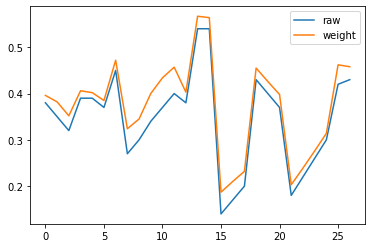

In [135]:
# Raw vs. weighted
prediction_df.plot()

## 加權分佈
從以下的加權分佈可以看到誤判為平行調的佔絕大多數。可能代表以最多出現次數的音視為主音的想法有一定的可靠度，但是每首樂曲可能因為時長不足，抑或曲風特性所致——爵士、藍調容易出現和弦外音可能剛巧反而符合相反大小調的音階分佈。

而判斷為完全五度及關係調的原因，可能是主音原本就找錯了（在以出現最多次的音作為主音的規則下），導致最後的結果出錯。
但全部大小調都比對一次或許也太過耗時，兩種作法間需做權衡。

In [136]:
columns = ['genre', 'chroma_operation','template_type', 'acc_type']
weighted_distribution_df = pd.DataFrame.from_dict({(i, j, k): weighted_distribution[i][j][k] 
                            for i in weighted_distribution.keys() 
                            for j in weighted_distribution[i].keys()
                            for k in weighted_distribution[i][j].keys()
                            }, orient='columns').T

weighted_distribution_df.reset_index(inplace=True)
weighted_distribution_df.columns = ['genre', 'chroma_operation','template_type', 'weighted_count_fifth', 'weighted_count_relative', 'weighted_count_parallel']

print(tabulate(weighted_distribution_df, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════╤════════════════════╤═════════════════╤════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│    │ genre   │ chroma_operation   │ template_type   │   weighted_count_fifth │   weighted_count_relative │   weighted_count_parallel │
╞════╪═════════╪════════════════════╪═════════════════╪════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│  0 │ disco   │ stft               │ data_driven     │                      1 │                         1 │                         4 │
├────┼─────────┼────────────────────┼─────────────────┼────────────────────────┼───────────────────────────┼───────────────────────────┤
│  1 │ disco   │ cqt                │ data_driven     │                      2 │                         2 │                         8 │
├────┼─────────┼────────────────────┼─────────────────┼────────────────────────┼───────────────────────────┼───────────────────────────┤
│  2 │ disco   │ cens               │ dat

<AxesSubplot:>

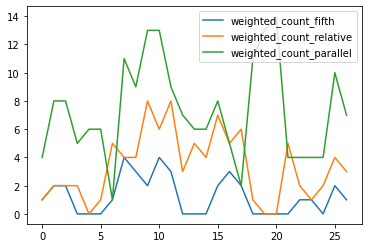

In [137]:
weighted_distribution_df.plot()

## 不同曲風
所得到的分數也會受不同曲風所影響，從下圖可以看出，在各個曲風中得分明顯較低的兩個類別為饒舌(hip-hop)和爵士(jazz)，而得分最高的則依序是：金屬(metal)、搖滾(rock)和藍調(blues)。<br/>
而藍調曲風得分最明顯改變，逆轉原來倒數的分數成為前三名，金屬也是獲得很明顯的漲幅，取得這裡得分的第一名。而除了 country, disco 和 rock 之外，其他曲風的得分都呈現增加的趨勢。<br/>

	
| genre | raw | weight | 使用 data driven 後分數(增減) | 增減標示 |
| ----- | --- | ------ | -------------------------- | ------- |
| blues | 0.136667 | 0.217000 | +0.263333, +0.209333 | ↑ |
| country | 0.426667 | 0.447333 | -0.04334, -0.36 | ↓ |
| disco | 0.356667 | 0.384000 | -0.006667, -0.346333 | ↓ |
| hiphop | 0.137778 | 0.174889 | +0.082222, +0.064444 | ↑ |
| jazz | 0.157778 | 0.199889 | +0.012222, +0.009778 | ↑ |
| metal | 0.388889 | 0.433111 | +0.097778, +0.078222 | ↑ |
| pop | 0.294444 | 0.345889 | +0.045556,  +0.034443 | ↑ |
| reggae | 0.376667 | 0.392333 | +0.006666, +0.005334 | ↑ |
| rock | 0.414444 | 0.465889 | -0.0444439, -0.035555 | ↓ |


In [138]:
group_by_genre = prediction_df.groupby("genre")
group_by_genre.mean()


,raw,weight
genre,,
blues,0.400000,0.426333
country,0.383333,0.411333
disco,0.350000,0.376667
hiphop,0.220000,0.239333
jazz,0.170000,0.209667
metal,0.486667,0.511333
pop,0.340000,0.380333
reggae,0.383333,0.397667
rock,0.370000,0.430333


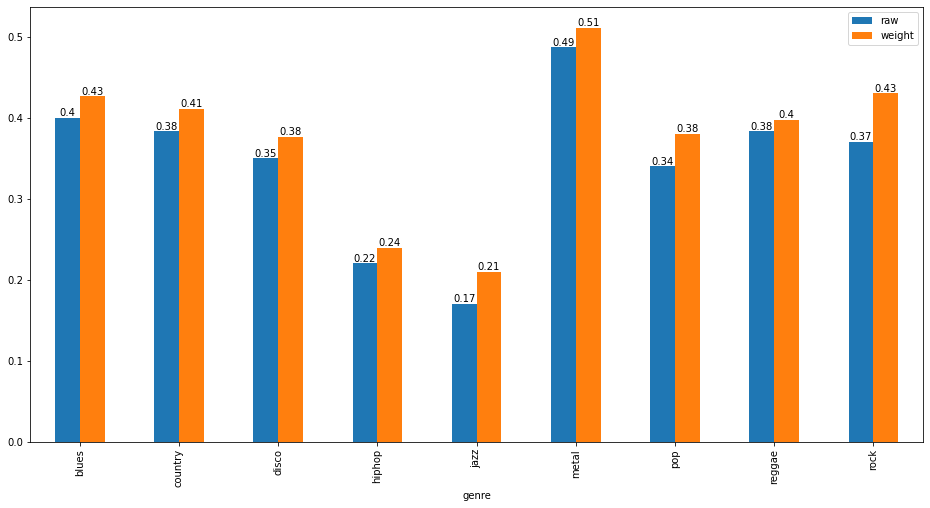

In [139]:
group_by_genre_mean = group_by_genre.mean()

ax = group_by_genre_mean.plot(kind='bar', figsize=(16, 8))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

## 不同 template 形式
使用 data driven方式來建立 24 種大小調的平均 chromagram template。<br/>
一個八度中採用 12 平均律可分為 12 個音高： C, C#, D, D#, E, F, F#, G, G#, A, A#, B<br/>
以下的分數比起其他 template 來得效果好，其原因便是因為直接從 dataset 中將各個 key 的 chromagram 曲平均值作為 template，一定程度上將依循此 dataset 的特性，獲得更佳的結果。
| template type| raw | weight |
| ------------ | --- | ------ |
| binary | 0.281481 | 0.326556
| harmonic | 0.316667 | 0.354259
| ks | 0.298519 | 0.339296

In [140]:
group_by_template_type = prediction_df.groupby("template_type")
group_by_template_type.mean()

,raw,weight
template_type,,
data_driven,0.344815,0.375889


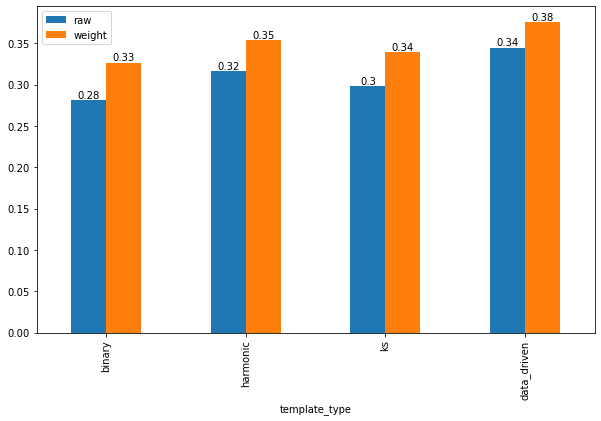

In [182]:
group_by_template_type_mean = group_by_template_type.mean()

# | binary | 0.281481 | 0.326556
# | harmonic | 0.316667 | 0.354259
# | ks | 0.298519 | 0.339296


df2 = pd.DataFrame([['binary', '0.281481', '0.326556'], [ 'harmonic', '0.316667', '0.354259'], ['ks', '0.298519', '0.339296']], columns=['template_type', 'raw', 'weight'])
df2_group_by = df2.groupby("template_type")
concat_item = [df2_group_by.mean(), group_by_template_type_mean]
result_group_by_format = pd.concat(concat_item)

ax = result_group_by_format.plot(kind='bar', figsize=(10, 6))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

## 不同 spectrogram 擷取方法
透過不同的時頻圖轉換方式，STFT、CQT 及 CENS 獲得 spectrogram 後再轉換為 chromagram。

● STFT：先將輸入訊號分成多個很短的固定時間區塊，透過 window function 的運算，取得 local time window 作瞬時的頻譜近似，每一個時間點都透過傅立葉轉換得到其對應的頻譜。
在此作業使用 window length = 4096 ，是因為 window 長度越能分辨精確的頻率。但當要處理的頻率域範圍非常廣，有些音比較長有些音比較短，很難把每個<br/>
● CQT：如果同一時間有很高音跟很低音同時出現， 但 window 較大適合處理低音，較小適合處理高音，無法兩全其美。使用 CQT 的目標在於對於不同頻帶都要做頻譜分析，每個 moment 都取不同長度的 window 作傅立葉轉換，雖然較麻煩但也較能處理同時出現的高低音分析。採用 log frequency scale，依照 12 平均律在一個八度內取 12 個 scale 。<br/>
● CENS(Chroma Energy Normalized)：CENS 的主要目標是在較長的 window 範圍上進行統計，可以平滑化節奏、發聲和音樂中的裝飾音（ex:顫音和琶音）所造成的局部偏差。chromagram 上可以看出比以上兩者更平滑。<br/>

在下圖中可以看出在 raw score 上 CQT 和 CENS 獲得同樣的分數，並高於 stft。而加權過後的分數在配合 data driven 與 dataset 時 CENS 的效果最好，其次是 CQT。

In [142]:
group_by_chroma_operation = prediction_df.groupby("chroma_operation")
group_by_chroma_operation.mean()

,raw,weight
chroma_operation,,
cens,0.354444,0.385222
cqt,0.347778,0.382889
stft,0.332222,0.359556


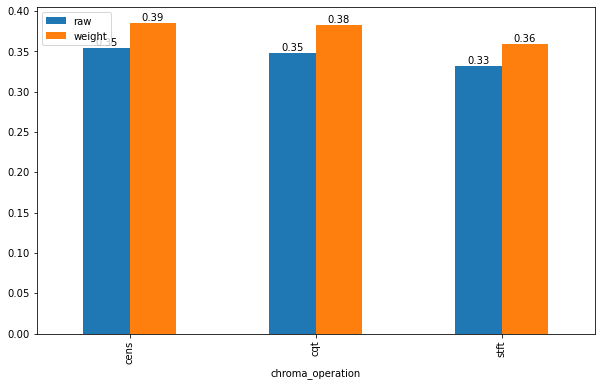

In [143]:
group_by_chroma_operation_mean = group_by_chroma_operation.mean()

ax = group_by_chroma_operation_mean.plot(kind='bar', figsize=(10, 6))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')